#### Daniel Oltean
### Publishers and printed books in the 17th-century Low Countries: An exploratory data analysis







#### Introduction

In this project, I focus on five types of information to describe and use the dataset of the books printed in the Low Countries in the 17th century: Language, Publisher, Place, Date, and Persons (involved in publishing, others than publishers). 


#### 1. The dataset in OpenRefine

In my dataset, I explore the following columns:

##### column '041' : Language
I create three new columns:

---- 041_Language, which contains the language of the publication (recorded in column '041' in subfield "a"), 

---- 041_Language_Original, which contains the original language of the translated publication (recorded in "h"),

---- 041_Language_Intermediate_Translation, which contains the intermediate language of the translation (recorded in "k").


##### column '64': Publisher, Place, and Date

For this column, I exploit the information provided by the online database of the books printed in Flanders before 1801, https://vlaamse-erfgoedbibliotheken.be/dossier/short-title-catalogus-vlaanderen/stcv.

To extract the relevant data, I create three new columns:

---- Publisher, recorded in subfield "b".

I use: 

value.replace("Typis ", "").replace("la vefue ", "").replace("bijde ", "").replace("imprimerie de ", "").replace("de weduwe ", ""), etc.

to obtain only the names of the publishers.

When the name of the publisher is not clearly indicated (the case of "Balthasar Moretus" I or II, etc.), I introduce the following names: Balthasar I Moretus, before 1641, Balthasar II Moretus, after 1641, Hieronymus I Verdussen, before 1635, Hieronymus II Verdussen, after 1635 (from 1647 he worked with Hieronymus III Verdussen), Hendrik I Aertssens, before 1654, Hendrik II Aertssens, after 1654, Geeraerdt I van Wolsschaten, before 1634, Geeraerdt II van Wolsschaten, after 1634, Hubertus Antonius I Velpius (and his widow), before 1634, Hubertus Antonius II Velpius, after 1634, Jan I Mommaert (and his widow), before 1637, Jan II Mommaert, after 1637, Jacob I van Meurs, before 1651, Jacob II van Meurs, after 1651, Martinus III Nutius, Joannes II Bellerus, Petrus III Bellerus III, Petrus II Zangrius, Jacob II Mesens, using, for example:

value.replace('Balthasar I Moretus', 'Balthasar II Moretus') if(cells.Date.value.substring(0, 4).toNumber() > 1641)


When several (2 or 3) publishers collaborate on the same book, I introduce “&” between their names.

---- Place, recorded in subfield "a".

I also use:

value.replace("A ", "").replace("En ", "").replace("In ", "").replace("Te ", "").replace("Tot", ""), etc.

to obtain proper data. I change the ancient names of the cities with the new ones (Augustæ Eburonum = Liège; Col. Agrippinæ = Cologne, Lugd. Bat. = Leiden, Ultrajecti = Utrecht, Insulis = Lille).

---- Date, recorded in subfield "c".

When the colophon and the front page are in contradictory (entries 216, 503, 974, 1141, etc.) I choose the front page or the later date; when a previous edition is mentioned in the colophon (entries 870, 1568, etc.), the info is ignored. 

##### column '700': Persons

For the persons involved in publishing, I create column '700Rec' containing names included in column '700' and identified with the help of function Reconciliation.

In my dataset, each cell of this column contains the identifiers and names of the persons, separated by a comma (e.g., Q112501006: Coenesteyn, Cornelis, Q112465041: Oliverius, Joannes).




#### 2. The dataset in Pandas and Gephi

I use a .csv file and exploit it in Pandas as a dataframe (df).

In [125]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
from IPython.display import HTML, Image
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
df = pd.read_csv('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/Assignment_2_Oltean.csv')

2.1. Languages

-- Number and languages of the published books:

In [126]:
books = df['041_Language'].value_counts().sum()
print(f'Number of books: {books}')
ser = df.groupby('041_Language')['001'].count().sort_values(ascending=False)
ser.index.name = 'Languages of published books:'
print(ser.to_string())

Number of books: 1713
Languages of published books:
lat                                       974
dut                                       578
fre                                       122
lat, grc                                    8
lat, dut                                    6
lat, dut, fre                               5
dut, fre                                    4
eng                                         3
ita                                         3
spa                                         3
fre, lat                                    2
dut, grc, lat                               1
fre, lat, ita                               1
fre, spa                                    1
lat, fre, dut, ger, spa, ita, eng, por      1
lat, spa                                    1



-- Number and original languages of the translated books:

In [127]:
transl_books = df['041_Language_Original'].value_counts().sum()
print(f'Number of translated books: {transl_books}')
ser = df.groupby('041_Language_Original')['001'].count().sort_values(ascending=False)
ser.index.name = 'Original languages:'
print(ser.to_string())

Number of translated books: 174
Original languages:
lat         70
spa         46
ita         22
fre         20
grc          6
ger          5
dut          3
lat, ita     1
por          1



-- Number of books translated via an intermediate language:

In [128]:
inter_books = df['041_Language_Intermediate_Translation'].value_counts().sum()
print(f'Number of books translated via an intermediate language: {inter_books}')
ser = df.groupby('041_Language_Intermediate_Translation')['001'].count().sort_values(ascending=False)
ser.index.name = 'Intermediate languages:'
print(ser.to_string())

Number of books translated via an intermediate language: 8
Intermediate languages:
fre    5
ger    1
ita    1
lat    1



2.2. Publishers:

-- Number of books published by the most prolific publishers:

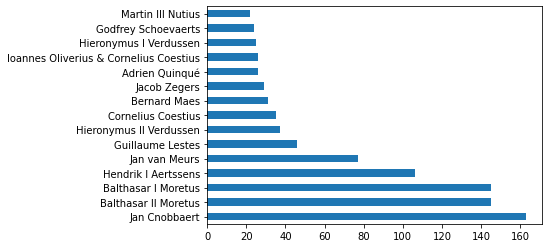

In [129]:
ax = df['Publisher'].value_counts()[:15].plot.barh()
plt.show()


Sometimes two or three publishers were involved in publishing books (the entries containing "&" in column Publisher).

Their names have been extracted in a new dataframe ("publishers_df") initially built with three columns ("Source", "Target", and "Name_3"). 

The third name has then been eliminated by introducing, in each case, two new rows containing this third name and the two related persons at the end of the dataframe.

In [130]:
publishers_df = df.loc[df['Publisher'].astype(str).str.contains('&')]['Publisher'].str.split(' & ', expand=True)
publishers_df.columns = ['Source', 'Target', 'Name_3']
my_index = publishers_df[publishers_df['Name_3'].notnull()].index
for my_number in my_index:
    publishers_df.loc[len(publishers_df.index)] = [publishers_df['Name_3'][my_number], publishers_df['Source'][my_number], 'None']
    publishers_df.loc[len(publishers_df.index)] = [publishers_df['Name_3'][my_number], publishers_df['Target'][my_number], 'None']
publishers_df.drop(columns=['Name_3'], inplace=True)  
publishers_df.reset_index(drop=True, inplace=True)
publishers_df


,Source,Target
0,Lambert de Grieck,Claudius de Grieck
1,Ioannes Oliverius,Cornelius Coestius
2,Ioannes Oliverius,Cornelius Coestius
3,Hieronymus II Verdussen,Guillaume Lestes
4,Hendrik I Aertssens,Jan van den Horick
...,...,...
96,Heyndrick I Aertsssens,Guillaume Lestes
97,Jan van Meurs,Balthasar I Moretus
98,Jan van Meurs,Jan Moretus
99,Jan van Meurs,Balthasar I Moretus



This dataframe is exported as a .csv file, visualised with Gephi, and then displayed in Notebook.
The visualization allows us to identify the special connection between Ioannes Oliverius and Cornelius Coestius (26 collaborations) and between Jan and Jacob van Meurs (9 collaborations).

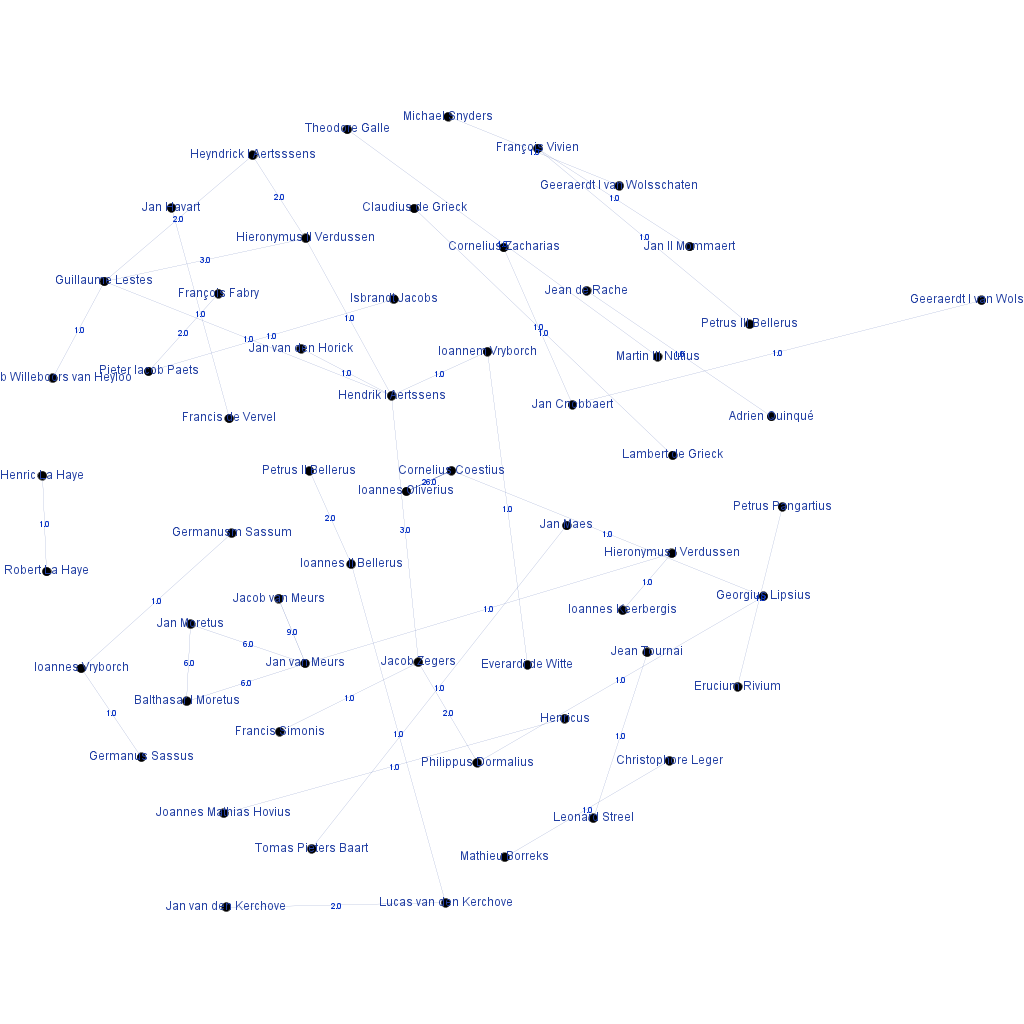

In [131]:
publishers_df.to_csv('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/publishers_df.csv', index=False, index_label=True)
display(Image('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/publishers_gephi.png', width = 400, height = 100))


2.3. Place of publication:

-- Top 15 places of publication and number of published books:

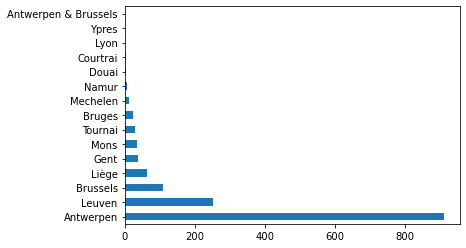

In [132]:
ax = df['Place'].value_counts()[:15].plot.barh()
plt.show()

Those cities are placed on the Belgian map using geopandas:


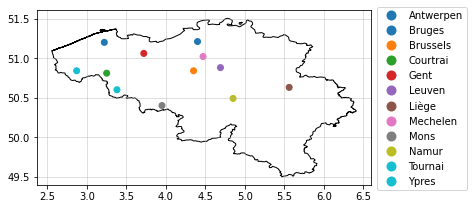

In [133]:
cities_df = pd.DataFrame(
                {
                'City': ['Antwerpen', 'Leuven', 'Brussels', 'Liège', 'Gent', 'Mons', 'Tournai', 'Bruges', 'Mechelen', 'Namur', 'Courtrai', 'Ypres'],
     
                'Latitude': [51.21, 50.88, 50.84, 50.63, 51.06, 50.4, 50.6, 51.20, 51.02, 50.49, 50.81, 50.84],
                'Longitude': [4.40, 4.69, 4.35, 5.56, 3.72, 3.95, 3.38, 3.22, 4.47, 4.85, 3.25, 2.87]
                }
    )
geo_cities_df = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df.Longitude, cities_df.Latitude))
belgium = gpd.read_file('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/stanford-hs337qd4914-shapefile/hs337qd4914.shp')
ax = belgium.plot(color='white', edgecolor='black')
ax.grid(visible=True, alpha=0.5)
geo_cities_df.plot(ax=ax, column='City', legend=True, legend_kwds={'bbox_to_anchor': (1.3, 1.05)})
plt.show()

-- Number of books published at Leuven by the top 15 most prolific publishers:

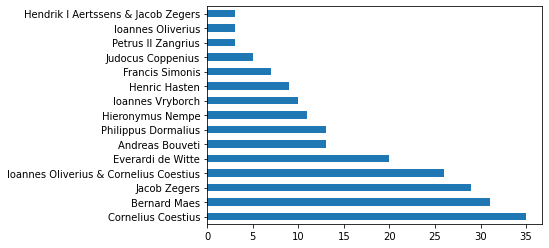

In [134]:
ax = df.loc[df['Place'] == 'Leuven']['Publisher'].value_counts()[:15].plot.barh()
plt.show()


2.4. Date of publication 

-- Number of books published per year (1540-1687):

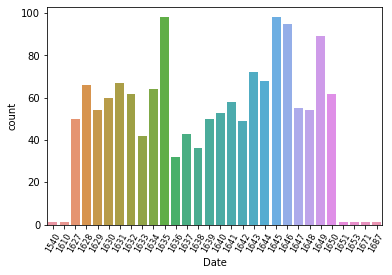

In [135]:
# The dates containing "-" and "," are ignored
selected_df = df.loc[~df['Date'].astype(str).str.contains('-|,')].sort_values('Date')
ax = sns.countplot(x='Date', data=selected_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=8)
plt.show()


-- Number of books per year published with the contribution of Balthasar I Moretus (1610-1641):

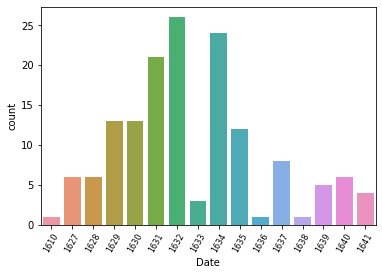

In [136]:
selected_df = df.loc[df['Publisher'].astype(str).str.contains('Balthasar I Moretus')].sort_values('Date')
ax = sns.countplot(x='Date', data=selected_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=8)
plt.show()


2.5. Persons 

-- Persons connected to publishers

First, I select the entries that have column '700Rec' not empty. Then, for the entries containing two or three publishers, I apply the same method as above, split the column 'Publisher', and add the names resulting after the split at the end of the dataframe.

In the next step, I read each entry of column '700Rec' in a list; each element of the list is added to a dictionary (to keep the link between the identifier and name). The publisher and person's identifier are added to a new dataframe (publisher_person_df) with two columns ('Source' and 'Target').

In [137]:
persons_df = df.loc[df['700Rec'].notnull()]
persons_df = persons_df[['Publisher', '700Rec']]
persons_df[['Publisher_1', 'Publisher_2', 'Publisher_3']] = persons_df.Publisher.str.split(' & ', expand = True)
index_Publisher_2 = persons_df[persons_df['Publisher_2'].notnull()].index
index_Publisher_3 = persons_df[persons_df['Publisher_3'].notnull()].index
for my_number in index_Publisher_2:
    persons_df.loc[len(persons_df.index)] = ['None', persons_df['700Rec'][my_number], persons_df['Publisher_2'][my_number], 'None','None']
    if my_number in index_Publisher_3:
        persons_df.loc[len(persons_df.index)] = ['None', persons_df['700Rec'][my_number], persons_df['Publisher_3'][my_number], 'None','None']
persons_df.drop(columns=['Publisher', 'Publisher_2', 'Publisher_3'], inplace=True)  
persons_df.reset_index(drop=True, inplace=True)

publisher_person_df = pd.DataFrame(columns=['Source', 'Target'])
len_publisher_person_df = 0

my_index = persons_df.index
my_dictionary = {}
for my_number in my_index:
    my_list =  persons_df['700Rec'][my_number].split('\n')
    for person in my_list:
        if person != '':
            Q = person.split(': ')[0]
            if Q not in my_dictionary:
                name = person.split(': ')[1]
                my_dictionary[Q] = name
            publisher_person_df.loc[len_publisher_person_df] = [persons_df['Publisher_1'][my_number] , Q]
            len_publisher_person_df += 1
publisher_person_df


,Source,Target
0,Guillaume Scheybels,Q17352432
1,Guillaume Scheybels,Q869133
2,Guillaume Scheybels,Q2342220
3,Guillaume Scheybels,Q1961244
4,Jan Cnobbaert,Q104224752
...,...,...
1230,Ioannem Vryborch,Q772704
1231,Cornelius Coestius,Q2679753
1232,Cornelius Coestius,Q124831
1233,Cornelius Coestius,Q55126959



I export this dataframe as a .csv file, visualise it with Gephi, and then display the result in Notebook.
The visualization allows to identify some persons with important roles in this network: Q869133 = Galle, Cornelius I, engraver (d. 1650, Antwerp), collaborator of many publishers, such as Balthasar I Moretus, Jan van Meurs, and Martin III Nutius; Q5599 = Rubens, Peter Paul (d. 1640, Antwerp); Q44281 = Urbanus WIII, pope (1623-1644); Q2265364 = Boonen, Jacobus archbishop of Mechelen (1621-1655).


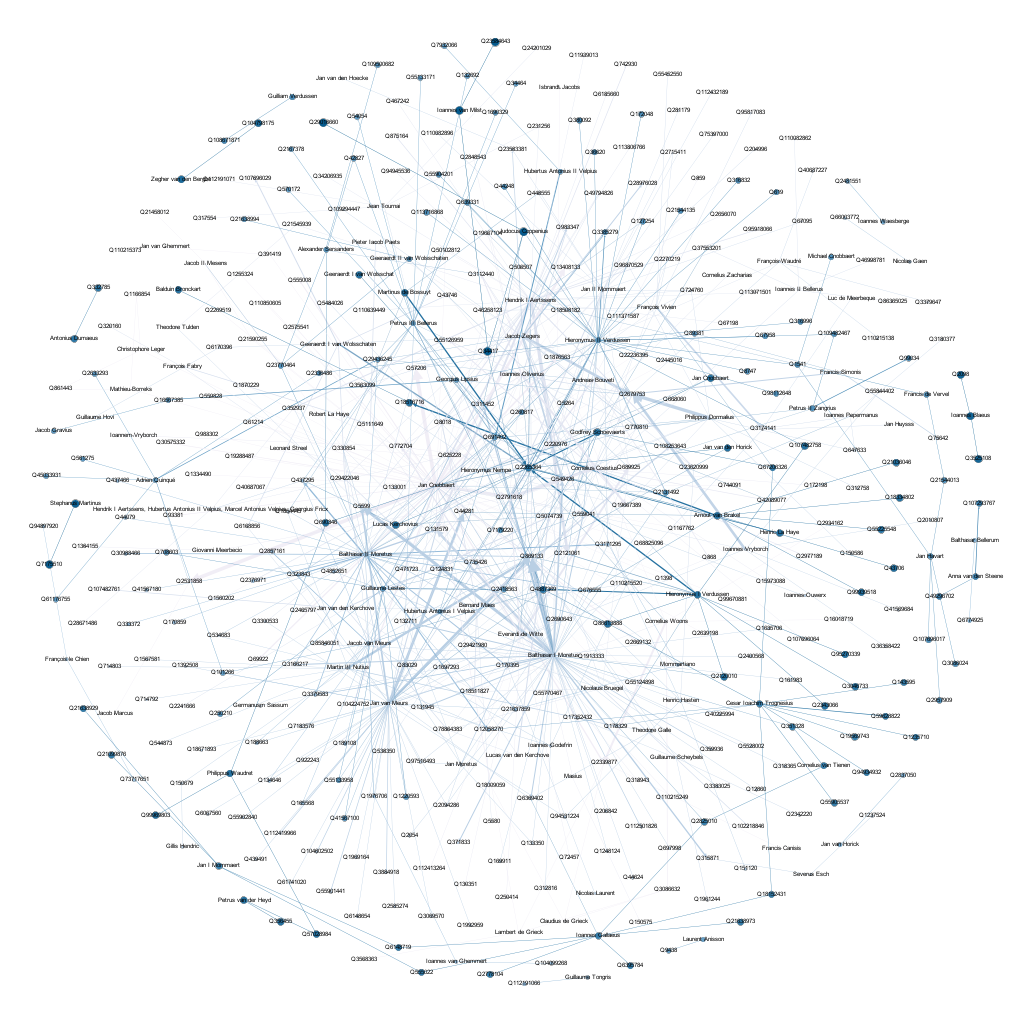

In [138]:
publisher_person_df.to_csv('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/publisher_person_df.csv', index=False, index_label=True)
display(Image('C:/Users/danie/Desktop/DH 2022-2023/Introduction to DH/Assignment2/publisher_person_gephi.png', width = 300, height = 400))